<a href="https://colab.research.google.com/github/victoriaaajiang/Arcade_Rhythm/blob/main/task2_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install opencv-python ultralytics filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=d0c71c160bad96fe5d4e913b967ec5f236cc7b1468ed44d185c0f57d03ebe417
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [2]:
#Install the video named video.mp4
!pip install yt-dlp
!yt-dlp -o "video.mp4" https://www.youtube.com/shorts/MwxxofLNpTg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.2 MB/s eta 0:00:00
[youtube] Extracting URL: https://www.youtube.com/shorts/MwxxofLNpTg
[youtube] MwxxofLNpTg: Downloading webpage
[youtube] MwxxofLNpTg: Downloading tv client config
[youtube] MwxxofLNpTg: Downloading player 6b3caec8
[youtube] MwxxofLNpTg: Downloading tv player API JSON
[youtube] MwxxofLNpTg: Downloading ios player API JSON
[youtube] MwxxofLNpTg: Downloading m3u8 information
[info] MwxxofLNpTg: Downloading 1 format(s): 247+251
[download] Destination: video.mp4.f247.webm
[download] 100% of    4.03MiB in 00:00:00 at 18.73MiB/s
[download] Destination: video.mp4.f251.webm
[download] 100% of  228.36KiB in 00:00:00 at 1.47MiB/s
[Merger] Merging formats into "video.mp4.webm"
Deleting original file video.mp4.f247.webm (pass -k to keep)
Deleting original file video.mp4.f251.webm (pass -k to keep)


100%|██████████| 38.8M/38.8M [00:00<00:00, 128MB/s]



0: 640x384 1 car, 982.1ms
Speed: 4.8ms preprocess, 982.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 899.2ms
Speed: 3.7ms preprocess, 899.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 1240.8ms
Speed: 3.2ms preprocess, 1240.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 1467.9ms
Speed: 3.9ms preprocess, 1467.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1054.7ms
Speed: 3.4ms preprocess, 1054.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 888.5ms
Speed: 3.9ms preprocess, 888.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 903.0ms
Speed: 9.8ms preprocess, 903.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 1 truck, 912.7ms
Speed: 3.5ms preprocess, 912.7ms inference, 1.3

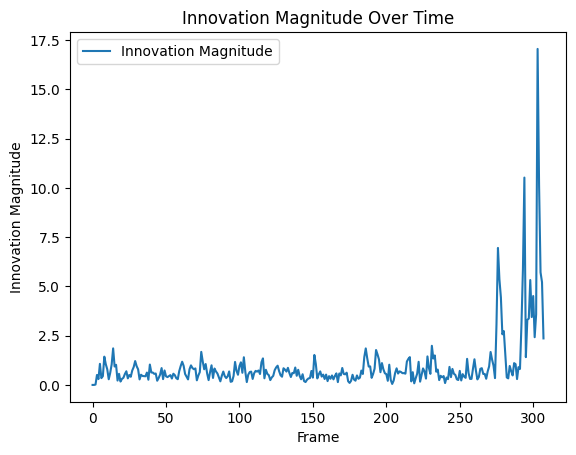

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from filterpy.kalman import KalmanFilter
from google.colab import files

# Load YOLOv11x model
model = YOLO('yolo11m.pt')

# Open the video file
video_path = "/content/video.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_path = "kalman.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Initialize Kalman Filter
def create_kalman_filter():
    kf = KalmanFilter(dim_x=4, dim_z=2)  # State: [x, y, vx, vy], Measurement: [x, y]
    kf.F = np.array([[1, 0, 1, 0],  # State transition matrix
                     [0, 1, 0, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0],  # Measurement function
                     [0, 1, 0, 0]])
    kf.P= 1000  # Covariance matrix (uncertainty)
    kf.R = np.array([[10, 0],  # Measurement noise
                     [0, 10]])
    kf.Q = np.eye(4) * 0.1  # Process noise
    return kf

kf = create_kalman_filter()

# Lists to store innovation magnitudes
innovation_magnitudes = []

# Process each frame
frame_count = 0
initialized = False
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)

    # Extract bounding boxes and centroids
    detections = []
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = box
            centroid = (int((x1 + x2) / 2), int((y1 + y2) / 2))
            detections.append(centroid)

    # Update Kalman Filter
    if len(detections) > 0:
        measurement = np.array([[detections[0][0]], [detections[0][1]]])  # Shape (2, 1)
        if not initialized:  # Initialize Kalman filter with the first detection
            kf.x = np.array([[measurement[0, 0]], [measurement[1, 0]], [0], [0]])  # Shape (4, 1)
            initialized = True
        else:
            kf.predict()
            kf.update(measurement)

        # Calculate innovation (difference between measurement and prediction)
        innovation = measurement - kf.H @ kf.x
        innovation_magnitude = np.linalg.norm(innovation)
        innovation_magnitudes.append(innovation_magnitude)

        # Draw bounding box, centroid, and Kalman filter prediction
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.circle(frame, (int(measurement[0, 0]), int(measurement[1, 0])), 5, (0, 0, 255), -1)
        predicted_position = (int(kf.x[0, 0]), int(kf.x[1, 0]))
        cv2.circle(frame, predicted_position, 5, (255, 0, 0), -1)

    # Write the frame to the output video
    out.write(frame)
    frame_count += 1

# Release resources
cap.release()
out.release()

# Plot innovation magnitude over time
plt.plot(innovation_magnitudes, label='Innovation Magnitude')
plt.xlabel('Frame')
plt.ylabel('Innovation Magnitude')
plt.title('Innovation Magnitude Over Time')
plt.legend()
plt.show()

# Download the processed video
files.download(output_path)